# What Are We Looking For?

**We assume "overpriced cars" to mean** <br>
**there exists a car C with features X and MSRP Y** <br>
**such that** <br>
**Y > Y' for a "similar" car C' with "similar" features X'** <br>

i.e. Cars are overpriced when there exists a similar car that's cheaper.

The same logic follows for underpriced cars.

# Inital Thoughts
 
My very first thought was to conduct some exploratory data analysis whereby I find the features which contribute most to MSRP, i.e. what factors contribute to a car’s price.
 
Then use these features to rank all the cars by MSRP and their “intrinsic” value, and look at the difference in rankings between each car in these two rankings. The issue is how to calculate intrinsic value.
 
I considered fitting multivariate curves (Gaussians/polynomials) to MSRP, calculating a score, and using it to find outlier cars that could correspond to under/overpriced cars. For example in the gaussian case, we might consider "score" as the probability of seeing this car given all the other cars.
 
Another approach that I thought about was to use PCA to reduce the dimensionality of the data and visualize to confirm whether these are true outliers in the data. 
 
In all of these cases, we would like to convert categorical/ordinal features to numeric ones.
 
In the end, I decided to create a model to predict the MSRP and look at the relative difference between the predicted and actual price of cars. In brief, this involved creating an XGBoost model to predict MSRP and using K-fold cross-validation to find the most under and overpriced cars in each fold.
 
Although it does involve creating a model, which I was trying to avoid, the model allows us to perform cross-validation which allows us to verify whether the car is incorrectly priced, whereas the other methods outlined can not easily do this.

# My Approach
 
My approach consisted of the followed steps:
* **Exploring the data**
    * Correlating all features to MSRP using (absolute) Pearson correlation coefficient, _r_
    * (Considered using Kendall Tau correlation coefficient but MSRP is not inherently ordinal. Although I could’ve converted all MSRPs to rankings, making it ordinal, I felt this was unnecessary)
* **Cleaning data**
    * Dropping useless features
    * Drop features that have a high proportion of missing values
    * Filling missing values (if low proportion of missing values)
    * Converting non-numeric features to numeric features (one-hot encoding)
* **Creating a prototype model**
    * Just to see if my idea will work
    * Split the data into train and test sets (validation sets came later)
    * Train XGBoost Regressor model to predict MSRP 
        * Using features that correlate to actual MSRP above 0.4 (i.e. _{|r|>0.4 for r(feature, MSRP) in features}_) as this is considered moderate to strong correlation in most academic papers
    * This model does not have to predict MSRP perfectly, since we're trying to model intrinsic value (not actual value), thus minimal hyperparameter tuning is performed.
        * A "low enough" error will suffice for this problem
* **5-fold cross-validation**
    * Split the data into 5 sets
    * Use 4 sets of the data to train, and test on the last set
    * Then find 10 most under/overpriced cars each K fold set (take note of it)
    * Repeat for all 5 sets
* **Most under/overpriced cars have the highest/lowest relative difference in MSRP among all K folds**
* **Create Final Model**
    * We need to create a final model as we can not use one of the five k fold models since we’d be testing on our train set
    * Instead, we take the 50 most under and over-priced cars (100 cars) and test on them, using all other cars as training data points
    * We then use this model’s final predictions and explain
* **Explain the model**
    * Use SHAP to see why the model predicted what it did, compared to the average predicted MSRP
    * SHAP is a game theoric approach to explaining a model’s output, it is based on if players (features) of a game (model) are/are not present, i.e. it figures out the contribution of each feature for any given prediction

We make a major assumption when creating a model: 
**We assume that the model’s prediction will be closer to the car’s "true intrinsic" value compared to its true MSRP.**
 
This approach has the flaw whereby a model’s incorrect predictions can easily be seen as outliers. 
 
We try to mitigate this by considering relative difference over the absolute difference.
 
Whereby if the model predicted `pred_msrp`=**£1,000** price for `true_msrp`=**£1,100** car, 
The relative difference would be (`true_msrp/pred_msrp`) 1,100/1,000 = 1.1
 
This means that the car in question is overpriced by 10%. We choose to use this relative method as price and utility of purchase are logarithmic in nature. 
 
The feeling of happiness when receiving £100,000 when you’re homeless is very different from receiving £100,000 when you’re a billionaire; 

This same logic applies to buying items and to model this we use relative price differences.

<br>
<br>
<br>
<br>

___
# Dependancies and Imports

Uncomment the cell below and run to download and install all dependencies. Please note, this notebook assumes you are using Conda/MiniConda for your Python instance.

If you do not have access to this, there is a html version of this notebook that can be viewed.

In [1]:
# # This cell will install all libraries needed for this Jupyter Notebook.
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install matplotlib
# !pip install seaborn
# !pip install xgboost
# !conda install -c conda-forge shap

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

shap.initjs()
pd.set_option('display.max_columns', None) # see all columns
sns.set(color_codes=True)
sns.set_theme(style="whitegrid")
%matplotlib inline 

<br>
<br>
<br>
<br>

___
# Exploring the Data

We will now read in the `car_data_cleaned.csv` and inspect the head of the dataframe containing the csv.

In [3]:
# Load and show first five rows of data
df = pd.read_csv("car_data_cleaned.csv")
df.head()

,Unnamed: 0,Car_Make_Model_Style,MSRP,Style Name,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,EPA Classification,Base Curb Weight (lbs),Front Hip Room (in),Front Leg Room (in),Second Shoulder Room (in),Passenger Volume,Second Head Room (in),Front Shoulder Room (in),Second Hip Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Track Width, Front (in)","Width, Max w/o mirrors (in)","Track Width, Rear (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),Fuel System,First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Final Drive Axle Ratio (:1),Steering Type,Turning Diameter - Curb to Curb,Front Wheel Material,Suspension Type - Front,Suspension Type - Rear,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Other Features,Basic Miles/km,Basic Years,Corrosion Miles/km,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Maximum Alternator Capacity (amps),Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Engine Configuration,Engine Class,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year
0,0,2019 Acura RDX Specs: FWD w/Technology Pkg,40600.0,FWD w/Technology Pkg,Front Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 2WD,3790.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,24.0,22.0,28.0,Gasoline Direct Injection,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,Rack-Pinion,39.0,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,50000.0,4.0,Unlimited,5.0,70000.0,6.0,50000.0,4.0,NaN,10.0,272.0,6500.0,280.0,1600.0,I,Turbocharged,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0
1,1,2019 Acura RDX Specs: FWD w/Advance Pkg,45500.0,FWD w/Advance Pkg,Front Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 2WD,3829.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,24.0,22.0,28.0,Gasoline Direct Injection,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,Rack-Pinion,39.0,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,50000.0,4.0,Unlimited,5.0,70000.0,6.0,50000.0,4.0,NaN,10.0,272.0,6500.0,280.0,1600.0,I,Turbocharged,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0
2,2,2019 Acura RDX Specs: FWD w/A-Spec Pkg,43600.0,FWD w/A-Spec Pkg,Front Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 2WD,3821.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,24.0,22.0,27.0,Gasoline Direct Injection,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,Rack-Pinion,39.0,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,50000.0,4.0,Unlimited,5.0,70000.0,6.0,50000.0,4.0,NaN,10.0,272.0,6500.0,280.0,1600.0,I,Turbocharged,2.0,122.0,255.0,255.0,20.0,20.0,1.0,1.0,4.0,2019.0
3,3,2019 Acura RDX Specs: FWD,37400.0,FWD,Front Wheel Drive,5,4,Sport Utility,Small Sport Utility Vehicles 2WD,3783.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,24.0,22.0,28.0,Gasoline Direct Injection,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,Rack-Pinion,39.0,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,50000

We will now describe the data. We see that MSRP has a mean of **46,757.18** with a minimum of **11,990.00** and a maximum of **548,800.00**.

In [4]:
# Describe data
df.describe()

,Unnamed: 0,MSRP,Passenger Capacity,Passenger Doors,Base Curb Weight (lbs),Front Hip Room (in),Front Leg Room (in),Second Shoulder Room (in),Passenger Volume,Second Head Room (in),Front Shoulder Room (in),Second Hip Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Track Width, Front (in)","Width, Max w/o mirrors (in)","Track Width, Rear (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Final Drive Axle Ratio (:1),Turning Diameter - Curb to Curb,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Maximum Alternator Capacity (amps),Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year
count,11457.000000,11408.000000,11457.000000,11457.000000,7516.000000,8628.000000,10892.000000,9744.000000,5915.000000,9780.000000,10838.000000,7713.000000,10840.000000,9799.000000,11440.000000,8290.000000,11365.000000,8289.000000,11383.000000,11306.000000,9581.000000,9976.000000,9477.000000,9999.000000,9931.000000,9936.000000,10751.000000,9862.000000,11448.000000,9933.000000,7541.000000,10850.000000,11457.000000,11457.000000,11396.000000,11457.000000,11457.000000,11087.000000,10933.000000,8296.000000,9928.000000,11419.000000,11284.000000,11400.000000,11394.000000,11306.000000,11018.000000,11456.000000,11456.000000,11457.000000,11457.000000,11456.000000,11457.000000,11449.000000,11457.000000
mean,5728.000000,46757.176893,5.038841,3.615344,3689.308010,56.967216,42.212651,57.461615,102.257481,38.309440,59.193844,55.659239,39.911078,36.823619,118.430554,62.587958,74.921134,62.720902,65.422194,20.065823,23.544202,20.672494,28.040308,4.238340,1.304408,2.596572,3.403453,0.999549,6.271139,1.746052,3.697087,39.891589,45814.983504,3.553810,6.481836,67949.885136,5.247360,70381.461712,4.180097,154.798819,6.686543,284.576670,5801.704449,288.479649,3460.741618,2.999204,203.254220,243.477654,239.910091,17.895697,17.881295,1.014541,1.000765,5.254695,2016.610806
std,3307.495351,39978.632981,1.458029,0.765427,641.898088,4.144232,1.571020,5.200195,22.214367,1.748564,4.558813,5.422354,2.447215,3.610456,17.497235,2.367172,3.916380,2.405747,10.063806,6.008546,6.234195,5.919908,6.101770,0.711329,0.278303,0.475001,0.702336,0.213591,1.961461,0.329057,0.956658,5.958573,17468.163488,0.730847,2.561833,20235.887070,1.445863,25537.497339,1.032423,32.269034,1.292068,109.087889,695.943028,111.579241,1276.605299,1.397192,86.169656,27.038376,23.468558,1.419031,1.404196,0.045984,0.006333,1.164542,1.833207
min,0.000000,11990.000000,1.000000,2.000000,1808.000000,45.400000,35.800000,39.700000,44.000000,31.000000,40.900000,41.700000,34.800000,24.600000,73.500000,50.500000,61.400000,54.500000,44.700000,1.900000,11.000000,10.000000,11.000000,2.260000,0.650000,1.520000,0.740000,0.530000,1.000000,0.450000,2.050000,17.500000,36000.000000,3.000000,3.000000,36000.000000,3.000000,25000.000000,2.000000,80.000000,1.000000,70.000000,1600.000000,68.000000,1000.000000,1.000000,55.000000,155.000000,155.000000,14.000000,14.000000,1.000000,1.000000,3.000000,2014.000000
25%,2864.000000,29120.000000,5.000000,4.000000,3263.000000,54.100000,41.200000,54.500000,92.800000,37.400000,55.900000,52.300000,38.600000,34.700000,106.300000,61.000000,72.200000,61.200000,57.400000,15.800000,19.000000,17.000000,24.000000,3.790000,1.060000,2.220000,3.060000,0.850000,6.000000,1.500000,3.160000,36.400000,36000.000000,3.000000,5.000000,60000.000000,5.000000,50000.000000,3.000000,130.000000,6.000000,190.000000,5500.000000,200.000000,2000.000000,2.000000,122.000000,225.000000,225.000000,17.000000,17.000000,1.00000

A better way to visualise the distribution of MSRPs in the dataset is with a box plot. The box plot below shows that the median MSRP falls around **46,757** with many cars being above this number.
 
This means that there are many expensive cars in the data set and very few cheap cars. However, this does not necessarily imply that there are many over-priced cars and few under-priced cars.

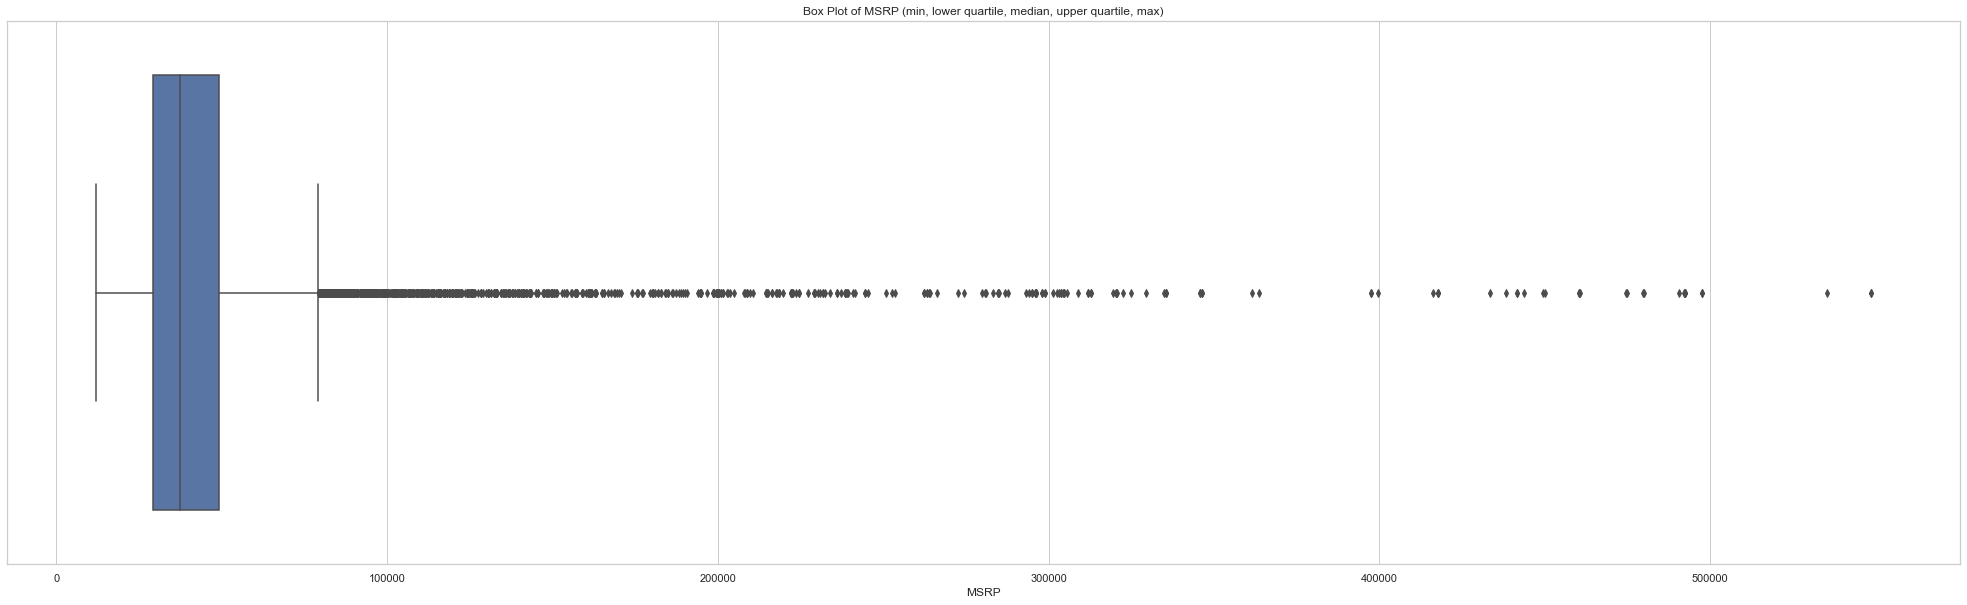

In [5]:
msrp_box_plot = sns.boxplot(x=df["MSRP"])
msrp_box_plot.set_title("Box Plot of MSRP (min, lower quartile, median, upper quartile, max)");
msrp_box_plot
fig = plt.gcf()
fig.set_size_inches(35, 10)

Now let's start the cleaning process, let's have a look at all columns and their data types. We see below that there are a lot of columns, not all of which will be useful for the purposes of prediction. 
 
We can also see that some of these columns are of datatype `object`. This means that the columns are **categorical or otherwise.**
 
XGBoost and Pandas both have features to deal with these columns, however, we have chosen to manually deal with them...

In [6]:
# Name and datatype of all columns
sorted([(col, str(dtype)) for (col, dtype) in zip(df.columns, df.dtypes)], key=lambda t: t[1]) 

[('MSRP', 'float64'),
 ('Base Curb Weight (lbs)', 'float64'),
 ('Front Hip Room (in)', 'float64'),
 ('Front Leg Room (in)', 'float64'),
 ('Second Shoulder Room (in)', 'float64'),
 ('Passenger Volume', 'float64'),
 ('Second Head Room (in)', 'float64'),
 ('Front Shoulder Room (in)', 'float64'),
 ('Second Hip Room (in)', 'float64'),
 ('Front Head Room (in)', 'float64'),
 ('Second Leg Room (in)', 'float64'),
 ('Wheelbase (in)', 'float64'),
 ('Track Width, Front (in)', 'float64'),
 ('Width, Max w/o mirrors (in)', 'float64'),
 ('Track Width, Rear (in)', 'float64'),
 ('Height, Overall (in)', 'float64'),
 ('Fuel Tank Capacity, Approx (gal)', 'float64'),
 ('Fuel Economy Est-Combined (MPG)', 'float64'),
 ('EPA Fuel Economy Est - City (MPG)', 'float64'),
 ('EPA Fuel Economy Est - Hwy (MPG)', 'float64'),
 ('First Gear Ratio (:1)', 'float64'),
 ('Fourth Gear Ratio (:1)', 'float64'),
 ('Second Gear Ratio (:1)', 'float64'),
 ('Reverse Ratio (:1)', 'float64'),
 ('Fifth Gear Ratio (:1)', 'float64'),
 (

In [7]:
# Name and datatype of all columns such that...
# columns are numeric
numeric_col_dtype = [(col, str(dtype)) for (col, dtype) in zip(df.columns, df.dtypes) if "obj" not in str(dtype)] 
# columns are NOT numeric
non_numeric_col_dtype = [(col, str(dtype)) for (col, dtype) in zip(df.columns, df.dtypes) if "obj" in str(dtype)]

Let's have a look at the numeric columns:
 
We see that **Unnamed: 0** is considered numeric when really it is an index, we decided to keep this column as it is useful for joining operations later on. We do not use this column for prediction purposes.
 
We can also see that some of these columns have `NaN` as a value (e.g. **Maximum Alternator Capacity (amps)**), these are missing values and will need to be removed/replaced.

In [8]:
# View first five rows of data, only show numeric columns
df[[col for (col, dtype) in numeric_col_dtype]].head() # just to inspect the values

,Unnamed: 0,MSRP,Passenger Capacity,Passenger Doors,Base Curb Weight (lbs),Front Hip Room (in),Front Leg Room (in),Second Shoulder Room (in),Passenger Volume,Second Head Room (in),Front Shoulder Room (in),Second Hip Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Track Width, Front (in)","Width, Max w/o mirrors (in)","Track Width, Rear (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Final Drive Axle Ratio (:1),Turning Diameter - Curb to Curb,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Maximum Alternator Capacity (amps),Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year
0,0,40600.0,5,4,3790.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,24.0,22.0,28.0,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,39.0,50000.0,4.0,5.0,70000.0,6.0,50000.0,4.0,NaN,10.0,272.0,6500.0,280.0,1600.0,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0
1,1,45500.0,5,4,3829.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,24.0,22.0,28.0,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,39.0,50000.0,4.0,5.0,70000.0,6.0,50000.0,4.0,NaN,10.0,272.0,6500.0,280.0,1600.0,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0
2,2,43600.0,5,4,3821.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,24.0,22.0,27.0,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,39.0,50000.0,4.0,5.0,70000.0,6.0,50000.0,4.0,NaN,10.0,272.0,6500.0,280.0,1600.0,2.0,122.0,255.0,255.0,20.0,20.0,1.0,1.0,4.0,2019.0
3,3,37400.0,5,4,3783.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,24.0,22.0,28.0,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,39.0,50000.0,4.0,5.0,70000.0,6.0,50000.0,4.0,NaN,10.0,272.0,6500.0,280.0,1600.0,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0
4,4,42600.0,5,4,4026.0,55.0,41.6,56.6,104.0,38.3,59.7,49.9,39.6,38.4,108.3,64.2,74.8,64.7,65.7,17.1,23.0,21.0,27.0,5.25,1.6,3.27,3.97,1.3,10.0,2.19,4.17,39.0,50000.0,4.0,5.0,70000.0,6.0,50000.0,4.0,NaN,10.0,272.0,6500.0,280.0,1600.0,2.0,122.0,235.0,235.0,19.0,19.0,1.0,1.0,5.0,2019.0


Similarly, let's have a look at the non-numeric columns:
 
Some of these columns will have no impact on the prediction of MSRP, for example, **Style Name**, is an arbitrary name given to styles of the car. No doubt, this does play some impact on pricing but we will not be using any NLP algorithms to extract its impact. Instead, we chose to simply drop these useless columns.
 
We also see that some columns contain values that are exclusive _Yes/No_ style answers, these can be transformed into 0s and 1s (not one-hot encoding).
 
Whereas other columns such as **Engine Configuration** are a finite set of possible values (_I, V, W, etc._), columns such as these are a perfect candidate for one-hot encoding. This is a method, whereby a single categorical column is transformed to _C_ numerical columns of 0s and 1s (where _C_ is the number of unique values or categories within that column). Note that one-hot encoding only makes sense when there are more than two unique non-numerical values:
 
An example of one-hot encoding is as follows:
 
e.g.
 
| categorical_column |
|:---:|
| A |
| B |
| C |
 
->
 
| categorical_column_A | categorical_column_B | categorical_column_C |
|:---:|:---:|:---:|
| 1 | 0 | 0 |
| 0 | 1 | 0 |
| 0 | 0 | 1 |
 
This is done so that algorithms such as XGBoost can utilise useful information, even if it is non-numerical.

In [9]:
# View first five rows of data, only show non-numeric columns
df[[col for (col, dtype) in non_numeric_col_dtype]].head() # just to inspect the values

,Car_Make_Model_Style,Style Name,Drivetrain,Body Style,EPA Classification,Fuel System,Steering Type,Front Wheel Material,Suspension Type - Front,Suspension Type - Rear,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Other Features,Corrosion Miles/km,Engine Configuration,Engine Class
0,2019 Acura RDX Specs: FWD w/Technology Pkg,FWD w/Technology Pkg,Front Wheel Drive,Sport Utility,Small Sport Utility Vehicles 2WD,Gasoline Direct Injection,Rack-Pinion,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,Unlimited,I,Turbocharged
1,2019 Acura RDX Specs: FWD w/Advance Pkg,FWD w/Advance Pkg,Front Wheel Drive,Sport Utility,Small Sport Utility Vehicles 2WD,Gasoline Direct Injection,Rack-Pinion,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,Unlimited,I,Turbocharged
2,2019 Acura RDX Specs: FWD w/A-Spec Pkg,FWD w/A-Spec Pkg,Front Wheel Drive,Sport Utility,Small Sport Utility Vehicles 2WD,Gasoline Direct Injection,Rack-Pinion,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,Unlimited,I,Turbocharged
3,2019 Acura RDX Specs: FWD,FWD,Front Wheel Drive,Sport Utility,Small Sport Utility Vehicles 2WD,Gasoline Direct Injection,Rack-Pinion,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,Unlimited,I,Turbocharged
4,2019 Acura RDX Specs: AWD w/Technology Pkg,AWD w/Technology Pkg,All Wheel Drive,Sport Utility,Small Sport Utility Vehicles 4WD,Gasoline Direct Injection,Rack-Pinion,Aluminum,Strut,Multi-Link,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Yes,Vehicle Stability Assist Electronic Stability ...,Unlimited,I,Turbocharged


We can deal with missing values by dropping rows, or filling them with a value (e.g. `0` or mean of that column).

Sometimes it is better to drop the entire column if the proportion of missing values is high.
 
Now, let's have a look at the proportion of missing values per column:
 
We see that columns such as **Passenger Volume** have a high proportion of missing values at around **48.3%**.

The cell below shows a tuple array of the form List(Tuple(**Column Name**, **Proportion of Missing Values**)):

In [10]:
prop_missing_vals_per_col = [(col, 1-df[col].notna().mean()) for col in df.columns]
prop_missing_vals_per_col = sorted(prop_missing_vals_per_col, key=lambda t: t[1], reverse=True)
prop_missing_vals_per_col[:25] # first 25 features ordered by the proportion of missing values

[('Passenger Volume', 0.4837217421663612),
 ('Base Curb Weight (lbs)', 0.34398184516016406),
 ('Final Drive Axle Ratio (:1)', 0.34179977306450204),
 ('Second Hip Room (in)', 0.3267871170463472),
 ('EPA Classification', 0.3197172034564022),
 ('Track Width, Rear (in)', 0.2765121759622938),
 ('Track Width, Front (in)', 0.2764248930784673),
 ('Maximum Alternator Capacity (amps)', 0.2759011957755084),
 ('Front Hip Room (in)', 0.24692327834511651),
 ('EPA Fuel Economy Est - Hwy (MPG)', 0.1728201099764336),
 ('Fuel Economy Est-Combined (MPG)', 0.16374269005847952),
 ('Second Shoulder Room (in)', 0.14951557999476306),
 ('Second Head Room (in)', 0.14637339617700973),
 ('Second Leg Room (in)', 0.14471502138430659),
 ('Fifth Gear Ratio (:1)', 0.13921619970323817),
 ('Gears', 0.13345552937069038),
 ('Fourth Gear Ratio (:1)', 0.133193680719211),
 ('Third Gear Ratio (:1)', 0.13301911495155805),
 ('Second Gear Ratio (:1)', 0.13275726630007856),
 ('EPA Fuel Economy Est - City (MPG)', 0.129265950947019

Perhaps these columns with a high proportion of missing values are important to MSRP.
 
Let's have a look at which columns correlate to MSRP the most.
 
We use the absolute Pearson correlation coefficient as it can indicate both negative and positive correlations with MSRP. 
 
It is usually used with continuous variables, which is ideal for MSRP - however, not all other features are continuous so these correlations are just to guide model selection.
 
Correlations above 0.3-0.4 are considered moderate, so correlations above this threshold are highly linked with increasing/decreasing MSRP.
 
We see that features related to a car’s performance are strongly linked with its MSRP, with **Net Horsepower** being the most indicative to a car’s price. Whereas other factors such as **Roadside Assistance Years** play little to no part in a car’s MSRP.

The cell below shows a tuple array of the form List(Tuple(**Column Name**, **Absolute Pearson Correlation Coefficient with MSRP**)):

In [11]:
# Correlate each column with MSRP
msrp_correlations = [(col, abs(df["MSRP"].corr(df[col]))) for (col, _) in numeric_col_dtype]

# Order by most to least correlated. 
msrp_correlations.sort(key=lambda t: t[1], reverse=True)

corr_threshold = 0.3
msrp_correlations_threshold = [(col, corr) for (col, corr) in msrp_correlations if corr>corr_threshold][1:]
msrp_correlations_threshold

[('Net Horsepower', 0.6756857921105897),
 ('Net Torque', 0.6251060538650953),
 ('Tire Width Ratio', 0.5773850457839491),
 ('Basic Miles/km', 0.5744428500291611),
 ('Rear Tire Width', 0.5423069552508987),
 ('Rear Wheel Size', 0.5086533378210475),
 ('Front Wheel Size', 0.4913105212659206),
 ('Base Curb Weight (lbs)', 0.4609164441195924),
 ('Displacement (L)', 0.4008159294713095),
 ('Displacement (cc)', 0.38614409533137983),
 ('EPA Fuel Economy Est - Hwy (MPG)', 0.37292374229702585),
 ('EPA Fuel Economy Est - City (MPG)', 0.3675740000552493),
 ('Fuel Economy Est-Combined (MPG)', 0.364829722632772),
 ('Tire Ratio', 0.36442895728548086),
 ('Track Width, Rear (in)', 0.3484596284734415),
 ('Track Width, Front (in)', 0.3443527775078663),
 ('Front Tire Width', 0.33933231084205284),
 ('Maximum Alternator Capacity (amps)', 0.30188673802529525)]

The cell below shows a tuple array of the form List(Tuple(**Column Name**, **Absolute Pearson Correlation Coefficient with MSRP**, **Proportion of Missing Values**)) sorted by descending Absolute Pearson Correlation Coefficient with MSRP

In [12]:
sorted([(col, abs(df["MSRP"].corr(df[col])), 1-df[col].notna().mean()) for (col, _) in numeric_col_dtype], key=lambda t: t[1], reverse=True)

[('MSRP', 1.0, 0.004276861307497604),
 ('Net Horsepower', 0.6756857921105897, 0.0033167495854062867),
 ('Net Torque', 0.6251060538650953, 0.00497512437810943),
 ('Tire Width Ratio', 0.5773850457839491, 8.728288382653382e-05),
 ('Basic Miles/km', 0.5744428500291611, 0.0),
 ('Rear Tire Width', 0.5423069552508987, 8.728288382653382e-05),
 ('Rear Wheel Size', 0.5086533378210475, 0.0),
 ('Front Wheel Size', 0.4913105212659206, 0.0),
 ('Base Curb Weight (lbs)', 0.4609164441195924, 0.34398184516016406),
 ('Displacement (L)', 0.4008159294713095, 0.013179715457798724),
 ('Displacement (cc)', 0.38614409533137983, 0.038317185999825476),
 ('EPA Fuel Economy Est - Hwy (MPG)', 0.37292374229702585, 0.1728201099764336),
 ('EPA Fuel Economy Est - City (MPG)',
  0.3675740000552493,
  0.12926595094701931),
 ('Fuel Economy Est-Combined (MPG)', 0.364829722632772, 0.16374269005847952),
 ('Tire Ratio', 0.36442895728548086, 0.0006982630706118265),
 ('Track Width, Rear (in)', 0.3484596284734415, 0.276512175962

_Note that the feature **Base Curb Weight** (weight of the car w/ full tank of fuel) is heavily correlated with MSRP (0.461). Despite being a good indicator of MSRP, we chose to drop this column as it had over 34% missing values - this would normally still be fine, but these missing values were prevalent in the most expensive cars in the dataset (Lamborghinis, etc) which might be overpriced. Removing these would run the risk of removing the most overpriced cars, thus we remove the column instead of the row._

To better visualise these correlations, see the plot below:

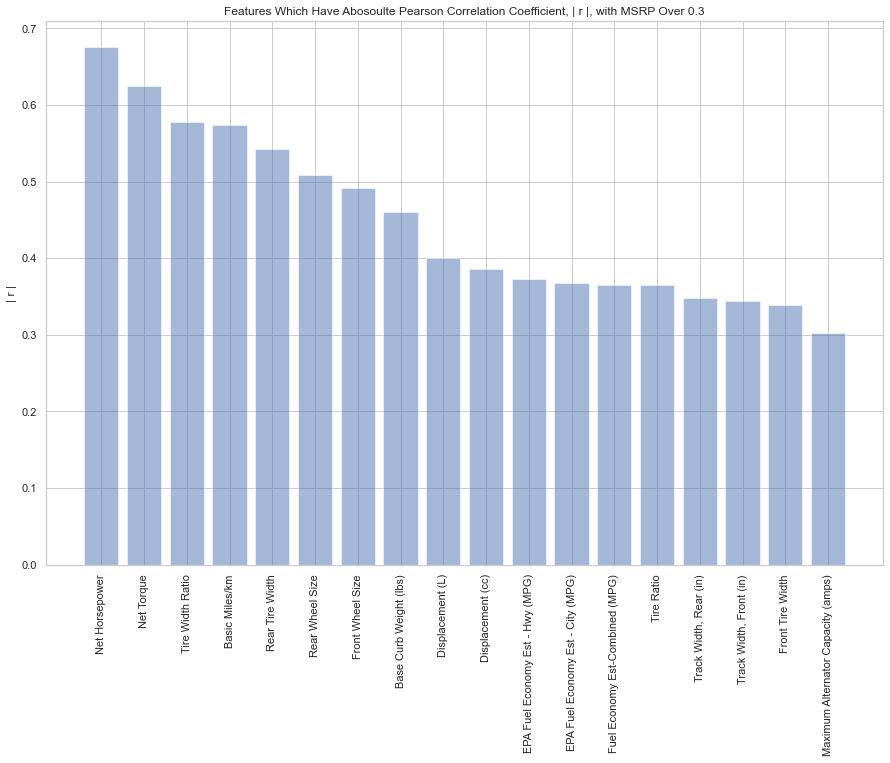

In [13]:
objects = [col for (col, corr) in msrp_correlations_threshold]
y_pos = np.arange(len(objects))
performance = [corr for (_, corr) in msrp_correlations_threshold]

plt.bar(y_pos, performance, align='center', alpha=0.5, color="b")
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('| r |')
plt.title(f'Features Which Have Abosoulte Pearson Correlation Coefficient, | r |, with MSRP Over {corr_threshold}')
fig = plt.gcf()
fig.set_size_inches(15, 10)

<br>
<br>
<br>
<br>

___
# Cleaning the Data

In [14]:
# Reload data, just incase I changed something
df = pd.read_csv("car_data_cleaned.csv")

We remove any rows which have missing data for MSRP, as this is the variable we are trying to predict.

In [15]:
# Remove rows where MSRP is N/A
df = df[df["MSRP"].notna()]

We remove any columns where the proportion of missing values > 0.2 (only columns with less than 20% missing data will be kept).
 
This is done as missing values can severely damage a model’s performance.
 
We do not conduct full feature engineering as we are only trying to find outlier cars.

If we were trying to predict price as accurately as possible, we would make more of an effort to keep as much useful data as possible.

In [16]:
# Remove columns where proportion of missing values > 0.2 (only columns with less than 20% missing data will be kept)
for col, prop_nas in prop_missing_vals_per_col:
    if prop_nas > 0.2:
        try:
            df = df.drop(col, axis=1)
        except KeyError:
            pass

We replace all missing values within numeric columns with `0`s. 
 
We briefly experimented with replacing all missing values within numeric columns with the mean of the column being considered, however, this heavily hurt the model’s performance, and thus we fill with `0`s instead.
 
Furthermore, XGBoost uses a sparse matrix representation to do gradient boosting, this means that `0`s in the data will help training time - allowing us to increase the number of estimator trees, lower learning rates, etc. Which may make up for missing values in the data.

In future work, we would like to experiment with filling missing values and assessing model performance

In [17]:
# # Fill numeric columns with 0s
# filler = 0
# for (col, dtype) in zip(df.columns, df.dtypes):
#     if "obj" not in str(dtype) and col != "Unnamed: 0": # if numeric column
#         if abs(df["MSRP"].corr(df[col])) > 0.3:
#             df[col].fillna(value=df[col].mean(), inplace=True)
#         else:
#             df[col].fillna(value=filler, inplace=True)

In [18]:
# Fill numeric columns with 0s
filler = 0
for (col, dtype) in zip(df.columns, df.dtypes):
    if "obj" not in str(dtype) and col != "Unnamed: 0": # if numeric column
        df[col].fillna(value=filler, inplace=True)

We also drop useless columns which have little to no impact on MSRP. 

If they do have an impact on price, it is not feasible to one-hot encode them as there are too many unique values and we want to keep dimensionality low for computability purposes.

In [19]:
# Drop "Style Name" and "Other Features" columns as they add no useful information
df = df.drop("Style Name", axis=1) 
df = df.drop("Other Features", axis=1)

We also convert `Yes`/`No` columns to `1`/`0` columns. This is done in place and does not increase the dimensionality of the data.

In [20]:
yes_no_cols = [col for col in df.columns if "Yes" in df[col].unique() or "No" in df[col].unique()]
for col in yes_no_cols:
    df[col] = df[col].eq("Yes").mul(1)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


For all other non numeric columns, we one-hot encode them as discussed above

In [21]:
# # Every other non-numeric column is useful, so we create a 1-k encoding for them to convert them to numeric
df = pd.get_dummies(df, dummy_na=False, columns=[col for (col, dtype) in zip(df.columns, df.dtypes) if "obj" in str(dtype)][1:])

Finally, we drop duplicates and visualise the sorted dataframe

In [22]:
# Drop rows with missing values (there shouldn't be any) and drop duplicate row entires
df = df.dropna(axis=0)
df = df.drop_duplicates()
# Sort by MSRP and show
df.sort_values(by="MSRP", ascending=False)

,Unnamed: 0,Car_Make_Model_Style,MSRP,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspension Type - Front_Short/Long Arm,Sus

In [23]:
# Describe cleaned data
df.describe()

,Unnamed: 0,MSRP,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspension Type - Front_Short/Long Arm,Suspension Type - Front_

<br>
<br>
<br>
<br>

___
# Training Data

We remove the labels, indices, and any other columns that may unfairly allow the model to predict price.
 
We then prepare training data `X`, which can be seen below:

In [24]:
# X data 
X = df[df.columns[3:]]
X = (X-X.min())/(X.max()-X.min()) # Normalise
# X = df[[c for (c, rr) in msrp_correlations_threshold]]
X

,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspension Type - Front_Short/Long Arm,Suspension Type - Front_Strut,Suspension

Similarly, we use the **MSRP** column as our `Y` target vector.

We also show the first three columns of the cleaned dataset to more easily identify the cars.

Non-numeric columns **Unnamed: 0** and **Car_Make_Model_Style** are kept to easily identify the cars, but these are not used in training.

In [25]:
# Y targets
Y = df[df.columns[2]]
print(Y)
df[df.columns[:3]]

0        40600.0
1        45500.0
2        43600.0
3        37400.0
4        42600.0
          ...   
11452    45700.0
11453    41200.0
11454    44850.0
11455    41000.0
11456    44650.0
Name: MSRP, Length: 11408, dtype: float64


,Unnamed: 0,Car_Make_Model_Style,MSRP
0,0,2019 Acura RDX Specs: FWD w/Technology Pkg,40600.0
1,1,2019 Acura RDX Specs: FWD w/Advance Pkg,45500.0
2,2,2019 Acura RDX Specs: FWD w/A-Spec Pkg,43600.0
3,3,2019 Acura RDX Specs: FWD,37400.0
4,4,2019 Acura RDX Specs: AWD w/Technology Pkg,42600.0
...,...,...,...
11452,11452,2018 Volvo V60 Cross Country Specs: T5 AWD Pla...,45700.0
11453,11453,2016 Volvo V60 Cross Country Specs: 4-Door Wag...,41200.0
11454,11454,2016 Volvo V60 Cross Country Specs: 4-Door Wag...,44850.0
11455,11455,2015 Volvo V60 Cross Country Specs: 2015.5 4-D...,41000.0


<br>
<br>
<br>
<br>

___
# Prototype Model

The prototype model is used just to see if the model works. We use an XGBRegressor which is a tree ensemble algorithm used for regression problems.

We chose to use this model as it is a scalable machine learning algorithm that has proven itself in many Machine Learning competitions (Kaggle). It uses more and more accurate approximations to find the best tree model, addressing the shortfalls of its predictions at every step, while remaining extremely interpretable.

We use a random seed of 42 and a test set size of 20%, i.e we train on 80% of the data and test on the remaining 20%.

We choose not to use validation sets as we do not care about fine-tuning the model’s predictions as we may overfit and miss the outlier cars.

In [26]:
# split data into train and test sets
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print(f"{X_train.shape=},\n{X_test.shape=},\n{y_train.shape=},\n{y_test.shape=}")
# X_train, X_test, y_train, y_test = X_test, X_train, y_test, y_train

X_train.shape=(9126, 205),
X_test.shape=(2282, 205),
y_train.shape=(9126,),
y_test.shape=(2282,)


In [27]:
# fit model no training data
model = XGBRegressor(n_estimators=1500, learning_rate=0.05)
model.fit(X_train, 
          y_train, 
          early_stopping_rounds=5,
          eval_set=[(X_test, y_test)],
          verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
# make predictions for test data
y_pred = model.predict(X_test)
print(f"{mean_absolute_error(y_test, y_pred)=}")

mean_absolute_error(y_test, y_pred)=1675.9682026628232


To visualise the model’s predictions, we will sort all cars by their MSRP and then predict the value of each of these cars and plot.

The plot below shows every car (_in 20% test set_) ordered by **true MSRP** (`blue`) and that car’s **predicted MSRP** (`orange`).

This allows us to easily visualise the absolute error for each car (not relative).

However absolute is not a good indicator of price in the eyes of humans as discussed prior.

We can also clearly see that the distribution of car prices is exponential.

In [29]:
true_pred_ys = sorted(list(zip(y_test, y_pred)), key=lambda t: t[0])
x_ax = range(len(true_pred_ys))

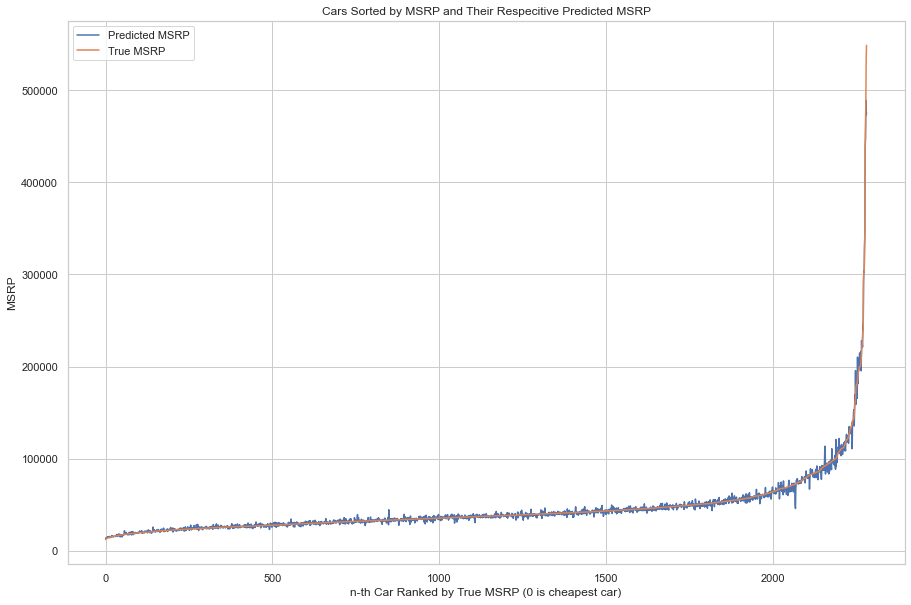

In [30]:
plt.plot(x_ax, [pred_y for (_, pred_y) in true_pred_ys], label="Predicted MSRP")
plt.plot(x_ax, [true_y for (true_y, _) in true_pred_ys], label="True MSRP")
plt.title("Cars Sorted by MSRP and Their Respecitive Predicted MSRP")
plt.ylabel("MSRP")
plt.xlabel("n-th Car Ranked by True MSRP (0 is cheapest car)")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.legend()
plt.show()

A good way to visualise exponential data is with logarithmic scales, i.e. transforming all data points, `d`, to `log(d)`

The plot below shows the same cars ordered by **log** MSRP and its respective **log** predicted MSRP.

Again, this does not show the relative difference, however, it allows us to better visualise the absolute differences. We see that the model is good at predicted the price of expensive cars. However, it is bad at predicting the price of cheap cars in terms of absolute price.

We can also use this plot as an indication of the model variance, which is relatively high - but the model is only being tested on a fifth of the total data.

We can use cross-validation to reduce the variance of these predications.

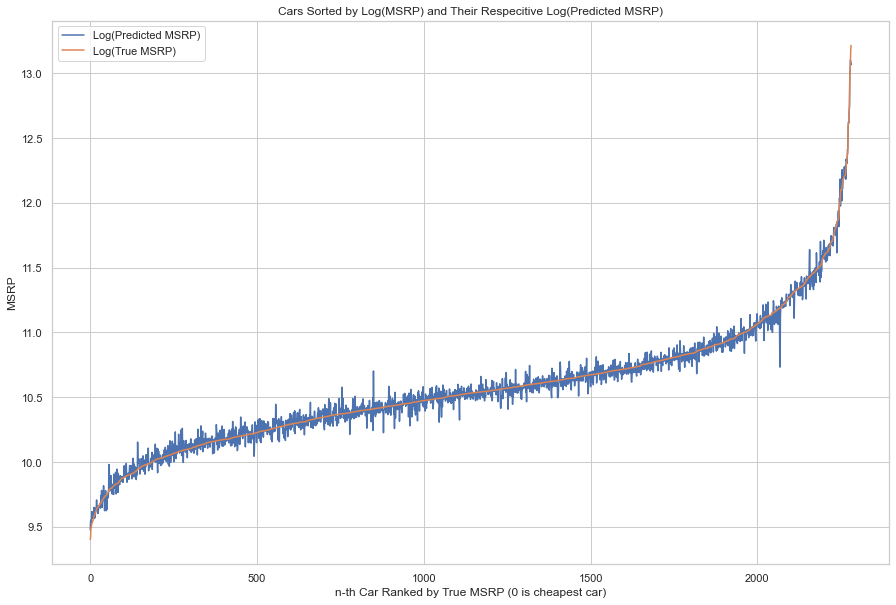

In [31]:
plt.plot(x_ax, [np.log(pred_y) for (_, pred_y) in true_pred_ys], label="Log(Predicted MSRP)")
plt.plot(x_ax, [np.log(true_y) for (true_y, _) in true_pred_ys], label="Log(True MSRP)")
plt.title("Cars Sorted by Log(MSRP) and Their Respecitive Log(Predicted MSRP)")
plt.ylabel("MSRP")
plt.xlabel("n-th Car Ranked by True MSRP (0 is cheapest car)")
fig = plt.gcf()
fig.set_size_inches(15, 10)

plt.legend()
plt.show()


The plot below shows the cars ordered by true MSRP, but this time the blue line shows the relative difference (ratio). 
 
This graph debunks our hypothesis that the model is predicting well on more expensive cars, **the model seems to be equally bad everywhere**.
 
This is actually not a bad thing as we do not need to consider class weights/undersampling to try and un-skew the data.
 
_The two data points furthest away from the orange line, above and below, are the most over and underpriced cars in this test set._

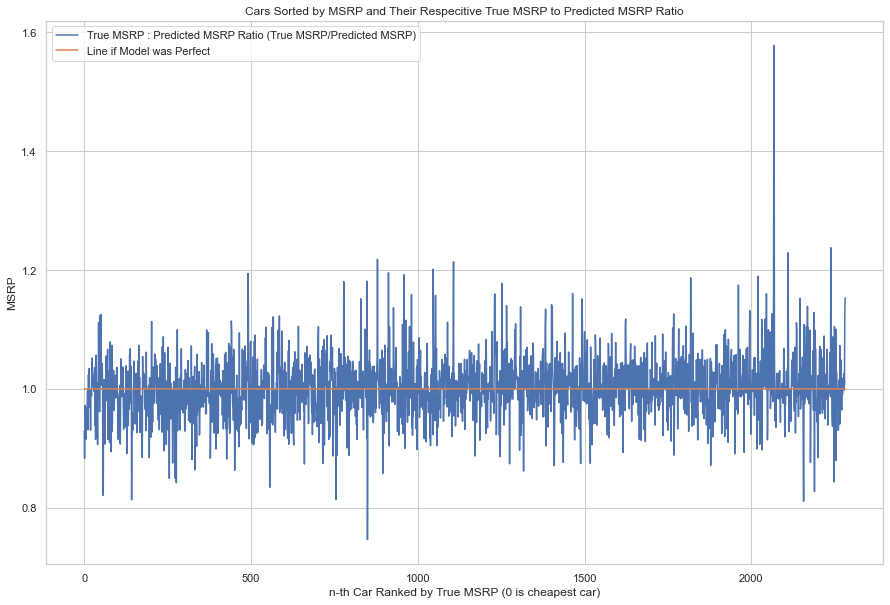

In [32]:
plt.plot(x_ax, [true_y/pred_y for (true_y, pred_y) in true_pred_ys], label="True MSRP : Predicted MSRP Ratio (True MSRP/Predicted MSRP)")
plt.plot(x_ax, [1 for _ in true_pred_ys], label="Line if Model was Perfect")

plt.title("Cars Sorted by MSRP and Their Respecitive True MSRP to Predicted MSRP Ratio")
plt.ylabel("MSRP")
plt.xlabel("n-th Car Ranked by True MSRP (0 is cheapest car)")
fig = plt.gcf()
fig.set_size_inches(15, 10)

plt.legend()
plt.show()


Now let’s have a look at what these two data points were.
 
First, we will look at the most over-priced car within **this test set**.
 
This car is a **2015 Chevrolet Camaro Specs: 2-Door Coupe Z/28**.
 
We deem this car as over-priced as we predicted a price of **45,825** but the actual price of the car is **72,305**. This is a **57.8%** mark-up!

In [33]:
i_test_pred_ratio = [(index, round(y_test), round(y_pred), y_test/y_pred) for (index, y_test, y_pred) in zip(y_test.index, y_test, y_pred)]
i_test_pred_ratio.sort(key=lambda t: t[3], reverse=True)
top_k = 10

print(f"Top {top_k} most OVER-priced cars, (df_index,  y_test,  y_pred,  y_test/y_pred):")
print(str(i_test_pred_ratio[:top_k]).replace("),", "),\n"))

overpriced_index, overpriced_true_msrp, overpriced_pred_msrp, overpriced_ratio = i_test_pred_ratio[0]
print(f"i.e. Most over-priced car in test set is:\n{overpriced_index=} car has max percentage increase of {overpriced_ratio:.3f} from predicted MSRP ({overpriced_pred_msrp}) to true MSRP ({overpriced_true_msrp})")

df[df["Unnamed: 0"] == overpriced_index]

Top 10 most OVER-priced cars, (df_index,  y_test,  y_pred,  y_test/y_pred):
[(2016, 72305, 45825, 1.5778517287801384),
 (2024, 72305, 50758, 1.424517995909627),
 (9853, 137000, 110708, 1.237490922232065),
 (6508, 82150, 66851, 1.2288499258613823),
 (6059, 33645, 27621, 1.2180812327098833),
 (5954, 36995, 30474, 1.2139783789839529),
 (5974, 35995, 29961, 1.2013823813843305),
 (5809, 34095, 28523, 1.1953399883538054),
 (7242, 27500, 23032, 1.1939662643475228),
 (5821, 34695, 29105, 1.1920484205249717)]
i.e. Most over-priced car in test set is:
overpriced_index=2016 car has max percentage increase of 1.578 from predicted MSRP (45825) to true MSRP (72305)


,Unnamed: 0,Car_Make_Model_Style,MSRP,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspension Type - Front_Short/Long Arm,Sus

Similarly, we deem **2018 Jeep Grand Cherokee Specs: Upland 4x4** to be the most under-priced car in **this test set** as the predicted price was **74.7%** of the actual price of the car.

Of course, these are just the outliers within our 20% test set.

In [34]:
i_test_pred_ratio.sort(key=lambda t: t[3], reverse=False)
print(f"Top {top_k} most UNDER-priced cars, (df_index,  y_test,  y_pred,  y_test/y_pred):")
print(str(i_test_pred_ratio[:top_k]).replace("),", "),\n"))

underpriced_index, underpriced_true_msrp, underpriced_pred_msrp, underpriced_ratio = i_test_pred_ratio[0]
print(f"i.e. {underpriced_index=} car has max percentage increase of {underpriced_ratio:.3f} from predicted MSRP ({underpriced_pred_msrp}) to true MSRP ({underpriced_true_msrp})")
df[df["Unnamed: 0"] == underpriced_index]

Top 10 most UNDER-priced cars, (df_index,  y_test,  y_pred,  y_test/y_pred):
[(5874, 33195, 44463, 0.7465705574680249),
 (5622, 92000, 113437, 0.8110257071595264),
 (5625, 92000, 113221, 0.8125698819758806),
 (2851, 20895, 25692, 0.8132815058552219),
 (5852, 31945, 39251, 0.8138611321179834),
 (2906, 17740, 21610, 0.8209298945710718),
 (2899, 17740, 21507, 0.824853342080545),
 (8503, 99990, 120863, 0.8273028451657121),
 (10786, 28700, 34395, 0.8344344115154493),
 (4196, 24070, 28582, 0.8421437606717175)]
i.e. underpriced_index=5874 car has max percentage increase of 0.747 from predicted MSRP (44463) to true MSRP (33195)


,Unnamed: 0,Car_Make_Model_Style,MSRP,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspension Type - Front_Short/Long Arm,Sus

<br>
<br>
<br>
<br>

___
# k-fold Cross-Validation Model

In this section, we will use 5-fold cross-validation which will create 5 different models which are tested on 5 unique test sets.
 
We take note of the 10 most overpriced cars and the 10 most underpriced cars when testing on each set. 
 
_These 20*5 cars are then used for the final model and SHAP explanations._
 
The procedure for K-fold cross-validation is as follows:
 
1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:<br>
    3.1 Take the group as a holdout or test data set <br>
    3.2 Take the remaining groups as a training data set<br>
    3.3 Fit a model on the training set and evaluate it on the test set<br>
    3.4 Retain the evaluation score and discard the model<br>
4. Summarize the skill of the model using the sample of model evaluation scores
 
We use k=5. This means that use 80% (4/5) of the data to train our model, and 20% (1/5) to test the model. We then pick the 10 most under and over-priced cars and take note of them.
 
We then consider the other 4/5 sets of data to test and train on. This is analogous to a rotating pie.

In [35]:
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
kf.get_n_splits(X)

i_test_pred_ratio = []
overpriced_in_kfold = []
underpriced_in_kfold = []

for kfold_number, (train_index, test_index) in enumerate(kf.split(X)):
     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
     y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

     # fit model no training data
     model = XGBRegressor(n_estimators=1500, learning_rate=0.05)
     model.fit(X_train, 
               y_train, 
               early_stopping_rounds=5,
               eval_set=[(X_test, y_test)],
               verbose=False)

     # make predictions for test data
     y_pred = model.predict(X_test)
     print(f"kfold={kfold_number+1} -> {mean_absolute_error(y_test, y_pred)=}")

     i_test_pred_ratio += [(index, f"{y_test:.2f}", f"{y_pred:.2f}", y_test/y_pred) for (index, y_test, y_pred) in zip(y_test.index, y_test, y_pred)]
     i_test_pred_ratio.sort(key=lambda t: t[3], reverse=True)

kfold=1 -> mean_absolute_error(y_test, y_pred)=1675.9682026628232
kfold=2 -> mean_absolute_error(y_test, y_pred)=1995.9642703083919
kfold=3 -> mean_absolute_error(y_test, y_pred)=2315.041644699003
kfold=4 -> mean_absolute_error(y_test, y_pred)=2067.5489861046417
kfold=5 -> mean_absolute_error(y_test, y_pred)=2292.854461362204


After 5-fold cross-validation, and taking note of the top 10 most under and overpriced cars in each fold, we now know the most over and underpriced cars and we can rank them.
 
But now we have the issue that we can not easily explain our model’s output with SHAP. 
 
If we pick any of the 5 models we have just created, we run the risk of testing on training datapoints. So instead we create a new final model which uses these outlier cars as test datapints.
 
But first, let’s have a look at what the 5-fold models outputted as the most under/overpriced cars:

<br>
<br>
<br>
<br>

___
# Rankings

We see that the most overpriced car over the 5 models is **2018 Mercedes-Benz G Class Specs: G 550 4x4 Squared** which had a **True:Predicted MSRP Ratio** at `1.86`.
 
This means that this car is almost double the price of what it should be.
 
This somewhat makes sense the G 550 or G-Wagon is a common status symbol for wealthy individuals.
 
We also see that the most underpriced car over the 5 models is **2016 Buick Regal Specs: 4-Door Sedan Sport Touring**. 
 
This again makes sense as this car is often used as a Police vehicle in the USA.
 
Being underpriced (**True:Predicted MSRP Ratio** at `0.66`) means it’s great value for money which is important for Police cars as they tend to do hundreds of thousands of miles.

In [36]:

df_outlier_cars = pd.DataFrame(i_test_pred_ratio, columns =['Index', 'True MSRP', 'Predicted MSRP', "True:Predicted MSRP Ratio"])
df_outlier_cars = df_outlier_cars.set_index('Index').join(df.set_index("Unnamed: 0"))
df_outlier_cars.drop("MSRP", axis=1, inplace=True)
df_outlier_cars = df_outlier_cars.sort_values(by=["True:Predicted MSRP Ratio"], ascending=False)
df_outlier_cars

,True MSRP,Predicted MSRP,True:Predicted MSRP Ratio,Car_Make_Model_Style,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspens

Looking at the top 10 most overpriced cars (in each fold) shows the trend that all of these cars are relatively high-performance sports cars. 
 
We saw that Net Horsepower was the most indicative of a car’s price and these are all fast cars or have big engines.
 
We also see the trend of electric/hybrid cars being classed as overpriced. This makes sense as with these cars, we are paying for the alternative fuel source and not the car specifically (longevity).

In [37]:
df_outlier_cars[:top_k]

,True MSRP,Predicted MSRP,True:Predicted MSRP Ratio,Car_Make_Model_Style,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspens

Looking at the top 10 most underpriced cars (in each fold) shows an odd trend.
 
Some of these cars are known for being cheap and great value for money. For example, the **2019 Dodge Challenger R/T Scat Pack Wide Body** is known for being great as they offer unrivaled horsepower for the money you pay, the essence of American muscle.
 
Strangely, the model deems cars such as the **2019 Rolls-Royce Cullinan Specs: Sport Utility** as under-priced, even though this again is a luxury car and by no means cheap. In addition, one would be paying for the Rolls-Royce brand name.
 
The model predicted the car to be more expensive than it actually is. We do not believe that the **2019 Rolls-Royce Cullinan Specs: Sport Utility** is actually overpriced, instead these are outlier predictions.
 
This is the main issue with this approach, if a car is predicted badly it can easily be recognised as an over/underpriced car. This is caused by our choice of metric, relative difference (`true_msrp/pred_msrp`) - it’s not perfect!
 
In instances like these, we use human expertise and domain knowledge combined with more rigorous cross-validation to iron out these outliers.
 
But since we are specifically concerned with outlier cars and not predicting as accurately as possible, we will not do this.
 
Instead, we will create a final model, whereby we use the top/bottom 50 cars to test on and train on the rest in our final model

In [38]:
df_outlier_cars[-top_k::][::-1]

,True MSRP,Predicted MSRP,True:Predicted MSRP Ratio,Car_Make_Model_Style,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspens

<br>
<br>
<br>
<br>

___
# Final Model and Results

As mentioned prior, this is our final model. We will use the top 50 most overpriced and underpriced cars in the ranking from our k-fold model (100 cars in total) to test out the model. 

This means that we will use the rest of the data to train on. I.e. this is a specific case of 99% training and 1% testing.
 
This will be our final model and we will use Shapely values to explain why the model predicted what it did (compared to its baseline prediction)


In [39]:
top_k = 50

# get indexes of top and bottom 50 cars in previous ranking (seen above)
indices_of_top_k_min = list(df_outlier_cars[-top_k::][::-1].index)
indices_of_top_k_max = list(df_outlier_cars[:top_k].index)
indices_of_top_k_min_and_max = indices_of_top_k_min + indices_of_top_k_max

In [40]:
# split data
X_train = X[X.index.isin([x_i for x_i in X.index if x_i not in indices_of_top_k_min_and_max])]
y_train = Y[Y.index.isin([y_i for y_i in Y.index if y_i not in indices_of_top_k_min_and_max])]
X_test = X.loc[indices_of_top_k_min_and_max]
y_test = Y.loc[indices_of_top_k_min_and_max]

# train model
model = XGBRegressor(n_estimators=1500, learning_rate=0.05)
model.fit(X_train, 
          y_train, 
          verbose=False)

y_pred = model.predict(X_test)
print(f"{mean_absolute_error(y_test, y_pred)=}")

i_test_pred_ratio_top_k = [(index, f"{y_test:.2f}", f"{y_pred:.2f}", y_test/y_pred) for (index, y_test, y_pred) in zip(y_test.index, y_test, y_pred)]

# push predictions into dataframe and join to og table
df_outlier_cars_top_k = pd.DataFrame(i_test_pred_ratio_top_k, columns =['Index', 'True MSRP', 'Predicted MSRP', "True:Predicted MSRP Ratio"])
df_outlier_cars_top_k = df_outlier_cars_top_k.set_index('Index').join(df.set_index("Unnamed: 0"))
df_outlier_cars_top_k.drop("MSRP", axis=1, inplace=True)
df_outlier_cars_top_k = df_outlier_cars_top_k.sort_values(by=["True:Predicted MSRP Ratio"], ascending=True)
df_outlier_cars_top_k

mean_absolute_error(y_test, y_pred)=20598.580751953126


,True MSRP,Predicted MSRP,True:Predicted MSRP Ratio,Car_Make_Model_Style,Passenger Capacity,Passenger Doors,Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),"Width, Max w/o mirrors (in)","Height, Overall (in)","Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),First Gear Ratio (:1),Fourth Gear Ratio (:1),Second Gear Ratio (:1),Reverse Ratio (:1),Fifth Gear Ratio (:1),Trans Type,Third Gear Ratio (:1),Turning Diameter - Curb to Curb,Air Bag-Frontal-Driver,Air Bag-Frontal-Passenger,Air Bag-Passenger Switch (On/Off),Air Bag-Side Body-Front,Air Bag-Side Body-Rear,Air Bag-Side Head-Front,Air Bag-Side Head-Rear,Brakes-ABS,Child Safety Rear Door Locks,Daytime Running Lights,Traction Control,Night Vision,Rollover Protection Bars,Fog Lamps,Parking Aid,Tire Pressure Monitor,Back-Up Camera,Stability Control,Basic Miles/km,Basic Years,Corrosion Years,Drivetrain Miles/km,Drivetrain Years,Roadside Assistance Miles/km,Roadside Assistance Years,Gears,Net Horsepower,Net Horsepower RPM,Net Torque,Net Torque RPM,Displacement (L),Displacement (cc),Rear Tire Width,Front Tire Width,Rear Wheel Size,Front Wheel Size,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Drivetrain_All Wheel Drive,Drivetrain_Four Wheel Drive,Drivetrain_Front Wheel Drive,Drivetrain_Rear Wheel Drive,Drivetrain_Rear wheel drive,Body Style_2dr Car,Body Style_3dr Car,Body Style_4dr Car,Body Style_Convertible,Body Style_Crew Cab Pickup,Body Style_Crew Cab Pickup - Long Bed,Body Style_Crew Cab Pickup - Short Bed,Body Style_Crew Cab Pickup - Standard Bed,Body Style_Extended Cab Pickup,Body Style_Extended Cab Pickup - Long Bed,Body Style_Extended Cab Pickup - Short Bed,Body Style_Extended Cab Pickup - Standard Bed,Body Style_Full-size Cargo Van,Body Style_Full-size Passenger Van,"Body Style_Mini-van, Cargo","Body Style_Mini-van, Passenger",Body Style_Regular Cab Pickup - Long Bed,Body Style_Regular Cab Pickup - Standard Bed,Body Style_Specialty Vehicle,Body Style_Sport Utility,Body Style_Station Wagon,Fuel System_DI,Fuel System_Diesel Direct Injection,Fuel System_Direct Injection,Fuel System_Electronic Fuel Injection,Fuel System_Electronic fuel injection,Fuel System_Gasoline Direct Injection,Fuel System_Hydrogen,Fuel System_MPI,Fuel System_Port/Direct Injection,Fuel System_SIDI,Fuel System_Sequential MPI,Fuel System_Sequential MPI (injection),Steering Type_4-Wheel Pwr Rack & Pinion,Steering Type_Electric,Steering Type_Electric Power Steering,Steering Type_Electric Pwr,Steering Type_Electric Pwr Steering,Steering Type_Electric Rack & Pinion,Steering Type_Electric Rack-&-Pinion,Steering Type_Electric Variable-Effort Power,Steering Type_Pwr,Steering Type_Pwr Electric Assist,Steering Type_Pwr Rack & Pinion,Steering Type_Pwr Rack-&-Pinion,Steering Type_Rack-Pinion,Steering Type_Re-Circulating Ball,Front Wheel Material_Aluminum,Front Wheel Material_Carbon Fibre,Front Wheel Material_Chrome,Front Wheel Material_Forged Aluminum,Front Wheel Material_Steel,Front Wheel Material_Styled Steel,Suspension Type - Front_Coil Over Strut,Suspension Type - Front_Coil Spring,Suspension Type - Front_Coil springs,Suspension Type - Front_Coil-Over Shock,Suspension Type - Front_Coil-Over Strut,Suspension Type - Front_Double Wishbone,Suspension Type - Front_Double Wishbone Pushrod,Suspension Type - Front_HiPER strut,Suspension Type - Front_HiPer Strut,Suspension Type - Front_HiPer strut,Suspension Type - Front_Independent,Suspension Type - Front_Independent Coil,Suspension Type - Front_Independent MacPherson Strut,Suspension Type - Front_Independent SLA,Suspension Type - Front_Leading Link,Suspension Type - Front_MacPherson Strut,Suspension Type - Front_MacPherson strut,Suspension Type - Front_Magnetic Ride Control,Suspension Type - Front_Multi-Link,Suspension Type - Front_Other,Suspension Type - Front_Short And Long Arm,Suspens

The cell above shows our final rankings for the 100 cars we tested on.

<br>
<br>
<br>
<br>

___
# Explaining the Model

We will now use SHAP to explain why the model predicted what it did compared to the model’s baseline rate.
 
SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of any machine learning model. 
 
This method was developed in Economics to find optimal payments for games given a player’s effort - this is analogous to feature importance on a prediction in an ML algorithm.
 
Please note that this is completely dependant on the model, this is not a ground truth!
 
It answers the question: **Why did my model predict what it did compare to it’s average prediction?**
 
It does NOT answer the question: **Why did my model predict what it did?**

In [41]:
explainer = shap.TreeExplainer(model)

shap_values = explainer(X_test,
                        y=y_test,
                        check_additivity=True)

shap_i_test_pred_ratio_top_k = [(shap_index, index, true_msrp, pred_msrp, ratio) for shap_index, (index, true_msrp, pred_msrp, ratio) in enumerate(i_test_pred_ratio_top_k)]
shap_i_test_pred_ratio_top_k.sort(key=lambda t: t[4], reverse=True)
# shap_i_test_pred_ratio_top_k

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<br>
<br>
<br>
<br>

___
# Most Over-Priced Cars

The below cell shows the top 3 most overpriced cars and their force plot. The force plot is a simple way of showing why the prediction is what it is starting from the mean prediction.

In [42]:
for shap_index, index, true_msrp, pred_msrp, ratio in shap_i_test_pred_ratio_top_k[:3]:
    name_of_car = df.loc[index]["Car_Make_Model_Style"]
    # print(f"Car = {name_of_car}, \nTrue MSRP = {true_msrp}, \nPredicted MSRP = {pred_msrp}, \nRatio (True/Predicted) = {ratio}")
    print(f"\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t{name_of_car}")
    plt = shap.force_plot(shap_values[shap_index])
    display(plt)

																2018 Mercedes-Benz G Class Specs: G 550 4x4 Squared SUV


																2019 Jaguar XE SV Specs: Project 8 AWD


																2018 Porsche 911 Specs: GT2 RS Coupe


___
# The Single Most Over-Priced Car,
# 2018 Mercedes-Benz G Class Specs: G 550 4x4 Squared SUV

The below cell shows an expanded force plot or waterfall plot of the most overpriced car in the dataset. 
 
We see that Net Horsepower was the largest contributing factor to the G-Wagon’s price, followed by its Real Wheel Size.
 
This is the 4x4 model which some consider a “monster-truck” as it is very high off the ground, we saw earlier that Wheel Size is heavily correlated with a car’s MSRP and this car has huge wheels.

Car = 2018 Mercedes-Benz G Class Specs: G 550 4x4 Squared SUV, 
True MSRP = 227300.00, 
Predicted MSRP = 120390.77, 
Ratio (True/Predicted) = 1.888018437874736


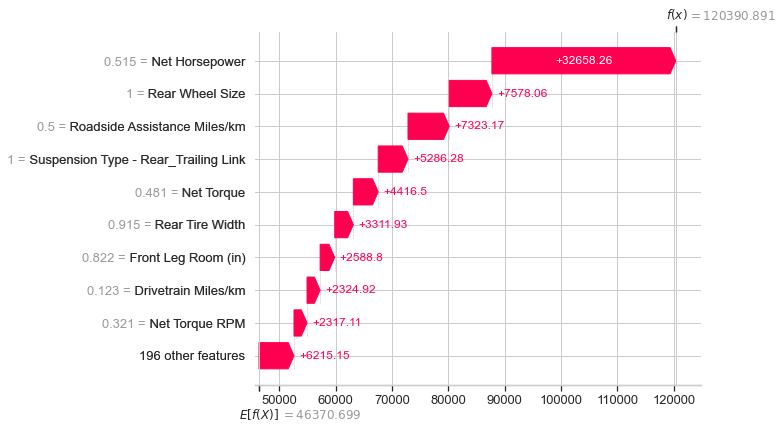

In [43]:
shap_index, index, true_msrp, pred_msrp, ratio = shap_i_test_pred_ratio_top_k[0]
name_of_car = df.loc[index]["Car_Make_Model_Style"]
print(f"Car = {name_of_car}, \nTrue MSRP = {true_msrp}, \nPredicted MSRP = {pred_msrp}, \nRatio (True/Predicted) = {ratio}")
shap.plots.waterfall(shap_values[shap_index])

<br>
<br>
<br>
<br>

___
# Most Under-Priced Cars

Similarly, the below cell shows the top 3 most under-priced cars and their respective force plots.

In [44]:
for shap_index, index, true_msrp, pred_msrp, ratio in shap_i_test_pred_ratio_top_k[-3:][::-1]:
    name_of_car = df.loc[index]["Car_Make_Model_Style"]
    print(f"Car = {name_of_car}, \nTrue MSRP = {true_msrp}, \nPredicted MSRP = {pred_msrp}, \nRatio (True/Predicted) = {ratio}")
    # print(f"\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t{name_of_car}")
    plt = shap.force_plot(shap_values[shap_index])
    display(plt)

Car = 2018 Jeep Grand Cherokee Specs: Altitude 4x4, 
True MSRP = 33195.00, 
Predicted MSRP = 47957.96, 
Ratio (True/Predicted) = 0.6921687672886009


Car = 2018 Jeep Grand Cherokee Specs: Upland 4x4, 
True MSRP = 33195.00, 
Predicted MSRP = 47957.96, 
Ratio (True/Predicted) = 0.6921687672886009


Car = 2019 Dodge Challenger Specs: R/T Scat Pack Widebody RWD, 
True MSRP = 38995.00, 
Predicted MSRP = 56335.17, 
Ratio (True/Predicted) = 0.6921963918103721


___
# The Single Most Over-Priced Car,
# 2018 Jeep Grand Cherokee Specs: Altitude 4x4

We can see the waterfall plot of the single most underpriced car in the dataset. Unusually, the car’s price is most affected by Basic Miles/km.
 
This was one of the columns which were set to 0 if it had a missing value, perhaps this may have played an important role in skewing some of these cars e.g. Cullinan.
 
The Jeep is also a large car, with its rear wheels falling at the 75th percentile, which should’ve driven up its price.
 
Overall, the reasons for this car being cheap are not so clear, however, the Jeep brand is again a car that is well known for its value for money and versatility.

Car = 2018 Jeep Grand Cherokee Specs: Altitude 4x4, 
True MSRP = 33195.00, 
Predicted MSRP = 47957.96, 
Ratio (True/Predicted) = 0.6921687672886009


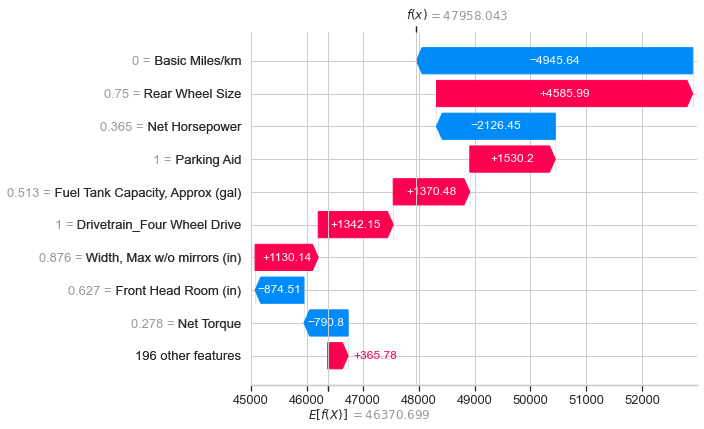

In [45]:
shap_index, index, true_msrp, pred_msrp, ratio = shap_i_test_pred_ratio_top_k[-1]
name_of_car = df.loc[index]["Car_Make_Model_Style"]
print(f"Car = {name_of_car}, \nTrue MSRP = {true_msrp}, \nPredicted MSRP = {pred_msrp}, \nRatio (True/Predicted) = {ratio}")
shap.plots.waterfall(shap_values[shap_index])